<a href="https://colab.research.google.com/github/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_5/cosmo_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyzing cosmological simulations
==================================

# Step 0: getting the data
In a bit, we will use the data from the TNG100-3 simulation. Since they are a bit large, better start the download now:

In [3]:
!wget https://datashare.mpcdf.mpg.de/s/ouBQP25OEh7tk55/download -O tng100-3.tar.gz
!mkdir tng100-3
!tar -xzf tng100-3.tar.gz -C tng100-3
!rm tng100-3.tar.gz

--2025-07-30 19:46:22--  https://datashare.mpcdf.mpg.de/s/ouBQP25OEh7tk55/download
Resolving datashare.mpcdf.mpg.de (datashare.mpcdf.mpg.de)... 130.183.207.3
Connecting to datashare.mpcdf.mpg.de (datashare.mpcdf.mpg.de)|130.183.207.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6238218548 (5.8G) [application/gzip]
Saving to: ‘tng100-3.tar.gz’

tng100-3.tar.gz     100%[===================>]   5.81G  36.5MB/s    in 2m 55s  

2025-07-30 19:49:18 (34.0 MB/s) - ‘tng100-3.tar.gz’ saved [6238218548/6238218548]



In [ ]:
# smaller simulation
!wget https://datashare.mpcdf.mpg.de/s/uYAfv1BYL3ffEf4/download -O small_sim_snap013.tar.gz
!mkdir small_sim
!tar -xzf small_sim_snap013.tar.gz -C small_sim
!rm small_sim_snap013.tar.gz

--2025-07-30 06:37:11--  https://datashare.mpcdf.mpg.de/s/uYAfv1BYL3ffEf4/download
Resolving datashare.mpcdf.mpg.de (datashare.mpcdf.mpg.de)... 130.183.207.3
Connecting to datashare.mpcdf.mpg.de (datashare.mpcdf.mpg.de)|130.183.207.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268939808 (256M) [application/gzip]
Saving to: ‘small_sim_snap013.tar.gz’

small_sim_snap013.t 100%[===================>] 256.48M  15.5MB/s    in 18s     

2025-07-30 06:37:29 (14.4 MB/s) - ‘small_sim_snap013.tar.gz’ saved [268939808/268939808]



# What is a cosmological simulation?
In astrophysics, numerical simulations are a fundamental tool. There are two main reasons why:
* stars, planets, galaxies, ... are extremely complex systems, so even if we understand basic physical laws, it's impossible to predict how these interact with pen and paper
* science is based on a cycle of observation-hypothesis-experiments, but in astrophysics we can not manipulate the Universe to make experiments. Therefore, we need to turn to virtual universes (simulations) to make virtual experiments

These simulations combine different ingredients:
* gravity
* fluid dynamics
* chemistry
* (sometimes) radiation
* (sometimes) magnetic fields

Then, starting from our best guess on the conditions of the Universe after the Big Bang, we evolve these synthetic universes until today and use them to run experiments, understand observations, etc.

Let's start with some visualizations to get an idea of what we are dealing with. For example, the distribution of matter in one of these simulations looks like this:

![cosmic_web_millenium](https://astrobites.org/wp-content/uploads/2012/07/cosmic-web.jpg)

If we start to zoom in, we can see individual galaxies, for example here;

![galaxy](https://github.com/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_5/tng_visual.png?raw=1)

# The AREPO code
There are many different simulations codes, and each one of them works in a different way and saves the data in different formats.

For this tutorial, we will work with a simulation produced with a code called AREPO. Let's familiarize with it a bit

## Types of resolution elements

### Fliuds (gas)

AREPO uses a 3D mesh to discretize fluids. For example, the continuous fluid on the left, can be discretized using a Cartesian mesh (right) where each cell represents the fluid in it.  

![mesh](https://github.com/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_5/mesh.png?raw=1)

AREPO is unique because it uses a Voronoi mesh, a much more general and adaptive mesh with respect to the Cartesian one.

![voronoi](https://github.com/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_5/voronoi.png?raw=1)

Even better, this mesh adapts to the gas flow, so that it's resolution is better where there is more 'action'

![khi](https://github.com/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_5/khi_arepo.png?raw=1)
![gal](https://github.com/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_5/gal_arepo.png?raw=1)

Each one of the cells contains a single value for each of the quantity describing the fluid. For example, it might contain: density, velocity and temperature. But only one value for each of these is allowed in each cell.

### Dark Matter
Dark Matter is a mysterious substance that makes up 80% of the mass in the Universe. It seems to interact only through gravity (so, no light, no electro-magnetic fields, etc.). Because of this, it is NOT a fluid. AREPO represents it using particles. These are not fundamental particles, but rather represent large "pieces" of the Universe. Often these "pieces" are millions of time larger than the solar system, but still tiny compared to (most) galaxies. These particles have, by construction, all the same mass.

### Stars
Stars are also represented using particles. In reality, stars are large spheres of self-gravitating, nuclear burning gas. In fact, we can use CFD codes (including AREPO) to simulate them. But they are so tiny compared to a galaxy or the entire Universe, that they are often represented by particles that interact through gravity only. (Stellar collision are so incredibly rare that they do not matter at the scales of these simulations)

### Black hole, tracers, low-res particles, ...
There are many more "things" that can be simulated in AREPO. For today, we are going to ignore them.

## Data format
AREPO outputs are most often in the [HDF5 format](https://www.hdfgroup.org/), but can also be in 2 other legacy format. For today, we will only use the HDF5 format.

AREPO, like most simulations of structure formation, has two main types of outputs (but there can be many more):
* **snapshots**: full outputs storing the individual resolution elements of the simulation: (Voronoi) mesh, dark matter partcles, stellar particles, ...
* **groups catalog**: collection of structures found in the simulation


### Snapshot
A snapshot, in practice, is an HDF5 file with different HDF5 Groups. One group, called `Header` contains meta-data about the file itself and the simulation that produced it. Another one (`Config`) contains the setup of AREPO used for the siulation. Each other group contains the data concerning one type of resolution element. These groups are named `PartTypeN`, with `N` starting from 0 and increasing. The table below shows what each type `N` represents.
  | Type | Meaning     |
  | ---- | ----------- |
  | 0    | Gas         |
  | 1    | Dark Matter |
  | 4    | Stars       |
  | 5    | Black holes |

Each particle type has a number of fields associated, that changes for each type. We will see below how to find out which one are available.
- If all particles of one type have the same mass, this is not saved in the fields, but rather in the `MassTable` attribute of the `Header` group

### Group catalogs
The group catalogs contain two types of structures: Groups and Subhalos.
* **Groups** represent collections of particles that are close to each other, but there is no guarantee that they are physically associated.
* **Subhaloes** represent collections of particles that are physically bound to each other. We usually think of these as galaxies.
In both cases, the halo catalogs contain only the _summary properties_ of these collections. For example, the _total_ mass of the subhalo, the average temperature, etc.

### File chunks
For efficiency reasons, a single snapshot or group catalog is often split into multiple _chunks_ that must be combined to obtain the full information. For today, the details are not important because we will use a library that does this for us.


### More info
- AREPO wiki (for public version only, but almost identical for the private version as well): https://gitlab.mpcdf.mpg.de/vrs/arepo/-/wikis/userguide/snapshotformat
- IllustrisTNG data specification: https://www.tng-project.org/data/docs/specifications/
- Thesan data specification: https://thesan-project.com/data.html

## Libraries
There are a few python libraries that can simplify the task of loading these data. For today's tutorial, we will use the [illustris_python](https://github.com/illustristng/illustris_python) library. You can install it in the following way:

In [1]:
!pip install --upgrade "git+https://github.com/illustristng/illustris_python.git"

  Cloning https://github.com/illustristng/illustris_python.git to /tmp/pip-req-build-qnz1jbp4
  Running command git clone --filter=blob:none --quiet https://github.com/illustristng/illustris_python.git /tmp/pip-req-build-qnz1jbp4
  Resolved https://github.com/illustristng/illustris_python.git to commit 2750c7d78270df78b3b3cd1c9e96eacc7512b59d
  Preparing metadata (setup.py) ... done
  Created wheel for illustris_python: filename=illustris_python-1.0.0-py3-none-any.whl size=15274 sha256=5f9c8d57e50515160121941962445665d04cdf1f868fc51dd55247631d1e4233
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ey2711o/wheels/86/e4/00/01ba77a18a39023ada98456194fcef8898c3484b7136857a78
Successfully built illustris_python


## Additional resources
- AREPO wiki: https://gitlab.mpcdf.mpg.de/vrs/arepo/-/wikis/home
- code paper: https://arxiv.org/abs/0901.4107
- further development paper: https://arxiv.org/pdf/1503.00562
- RT solver paper: https://academic.oup.com/mnras/article/485/1/117/5303742
- introduction to the code (by me):  https://datashare.mpcdf.mpg.de/s/TmjvOoDm4Nm4Pnv

# Step 1: simple data exploration
Let's start by simply checking the data we have available.

In [64]:
import h5py
import numpy as np

print("SNAPSHOT FILE")
with h5py.File(f'tng100-3/output/snapdir_098/snap_098.0.hdf5', 'r') as snapfile:

    print("HDF5 groups available:")
    for group_name in snapfile.keys():
        print(f" - {group_name}")
    print()

    #print the attributes of the 'Header' group
    header = snapfile['Header']
    print("Attributes in the Header group:")
    for attr_name, attr_value in header.attrs.items():
        print(f" - {attr_name}: {attr_value}")
    print()

    #print the datasets available for each particle type:")
    for part_type in snapfile.keys():
        if part_type.startswith('PartType'):
            print(f"Particle type: {part_type}")
            part_data = snapfile[part_type]
            for dataset_name in part_data.keys():
                print(f" - {dataset_name}: shape {part_data[dataset_name].shape}, dtype {part_data[dataset_name].dtype}")
            print()

  # Let's do the same for the group catalogs
print("\nGROUP FILE")
with h5py.File(f'tng100-3/output/groups_098/fof_subhalo_tab_098.0.hdf5', 'r') as groupfile:

  print("HDF5 groups available:")
  for group_name in groupfile.keys():
      print(f" - {group_name}")
  print()

  #print the dataset available for groups and subhaloes
  print('Group datasets')
  for dataset_name in groupfile['Group'].keys():
      print(f" - {dataset_name}: shape {groupfile['Group'][dataset_name].shape}, dtype {groupfile['Group'][dataset_name].dtype}")
  print()

  print('Subhalo datasets')
  for dataset_name in groupfile['Subhalo'].keys():
      print(f" - {dataset_name}: shape {groupfile['Subhalo'][dataset_name].shape}, dtype {groupfile['Subhalo'][dataset_name].dtype}")

SNAPSHOT FILE
HDF5 groups available:
 - Config
 - Header
 - Parameters
 - PartType0
 - PartType1
 - PartType4
 - PartType5

Attributes in the Header group:
 - BoxSize: 75000.0
 - Composition_vector_length: 0
 - Flag_Cooling: 1
 - Flag_DoublePrecision: 0
 - Flag_Feedback: 1
 - Flag_Metals: 0
 - Flag_Sfr: 1
 - Flag_StellarAge: 0
 - Git_commit: b'd203ec8b07c7e2bdda5f608aa0babea46d603699'
 - Git_date: b'Thu Apr 7 14:14:27 2016 +0200'
 - HubbleParam: 0.6774
 - MassTable: [0.         0.03235675 0.         0.00302063 0.         0.        ]
 - NumFilesPerSnapshot: 7
 - NumPart_ThisFile: [12687804 13349540        0        0   329031     4397]
 - NumPart_Total: [88953586 94196375        0        0  2234312    30546]
 - NumPart_Total_HighWord: [0 0 0 0 0 0]
 - Omega0: 0.3089
 - OmegaBaryon: 0.0486
 - OmegaLambda: 0.6911
 - Redshift: 0.009521666967944764
 - Time: 0.99056814006128
 - UnitLength_in_cm: 3.085678e+21
 - UnitMass_in_g: 1.989e+43
 - UnitVelocity_in_cm_per_s: 100000.0

Particle type: Par

In [5]:
with h5py.File('tng100-3/output/snapdir_098/snap_098.0.hdf5', 'r') as snapfile:
    print(snapfile['PartType0/Coordinates'][:10])

[[  859.0177  26337.934   18300.203  ]
 [  860.2749  26333.615   18303.49   ]
 [  855.16754 26336.504   18301.51   ]
 [  860.8275  26334.652   18298.73   ]
 [  863.92334 26340.432   18312.426  ]
 [  864.62616 26338.238   18308.762  ]
 [  848.9527  26347.947   18303.516  ]
 [  856.10535 26333.023   18295.262  ]
 [  852.23474 26329.668   18299.854  ]
 [  857.6006  26337.043   18320.324  ]]


## File chunks and illustris_python
As mentioned, snapshot files are split in chunks, each one with (potentially) a different number of particles.

In [6]:
with h5py.File('tng100-3/output/snapdir_098/snap_098.0.hdf5', 'r') as snapfile:
    Nfiles = snapfile['Header'].attrs['NumFilesPerSnapshot']

for ifile in range(Nfiles):
    with h5py.File(f'tng100-3/output/snapdir_098/snap_098.{ifile}.hdf5', 'r') as snapfile:
        print(f"File {ifile}:", snapfile['Header'].attrs['NumPart_ThisFile'])

File 0: [12687804 13349540        0        0   329031     4397]
File 1: [12659106 13531482        0        0   320019     4283]
File 2: [12726033 13457741        0        0   315224     4231]
File 3: [12699775 13468331        0        0   304919     4395]
File 4: [12739698 13509973        0        0   307796     4370]
File 5: [12707571 13482998        0        0   350352     4542]
File 6: [12733599 13396310        0        0   306971     4328]


So, if we want to load all gas particles, we have to explicitly loop over all files. For example:

In [7]:
gas_positions = []

for ifile in range(Nfiles):
    with h5py.File(f'tng100-3/output/snapdir_098/snap_098.{ifile}.hdf5', 'r') as snapfile:
        gas_positions.append(snapfile['PartType0/Coordinates'][:])

Or, we can use the `illustris_python` to do this for us.

In [8]:
import illustris_python as il
?il.snapshot.loadSubset

In [9]:
gas_data = il.snapshot.loadSubset('tng100-3/output', 98, 0, fields=['Coordinates', 'GFM_Metallicity'])

# Step 2: visualization
Let's start by checking how the simulation _looks like_. Naturally, the final results depends on what and how we plot. And naturally, this is not enough for scientific results. But it really helps to understand what is going on in the simulation.

## Slice
A slice is simply a plot of all particles/grid cells/etc in a _slice_ through the simulation box, or one of their properties. The simplest thing we can do, is just to plot one dot per particle.

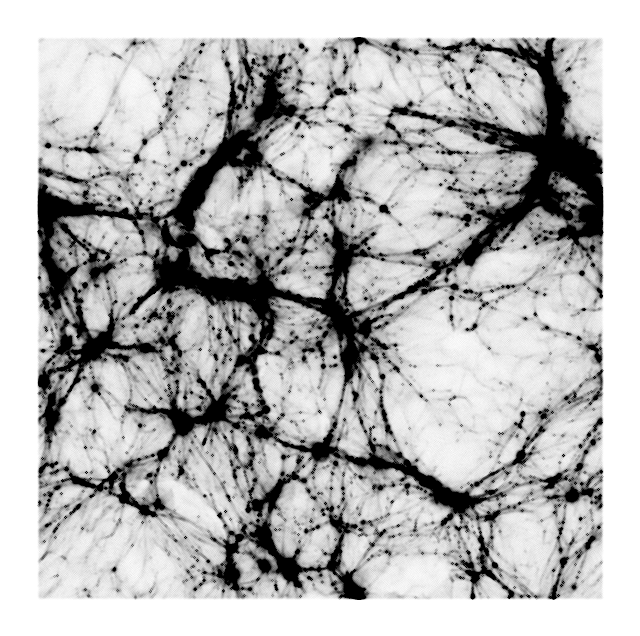

In [10]:
import matplotlib.pyplot as plt

min_z = 50000
max_z = 60000

slice_mask = (gas_data['Coordinates'][:, 2] >= min_z) & (gas_data['Coordinates'][:, 2] < max_z)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(gas_data['Coordinates'][slice_mask, 0], gas_data['Coordinates'][slice_mask, 1], s=0.001, c='k', alpha=0.1)
ax.set_axis_off()
fig.show()

We can see the **cosmic web**! But the dense parts are saturated because there are too many particles close to each other. We can fix this in few ways:
* play with point size and transparency
* make the slice thinner
* change how we plot this
Let's do the last

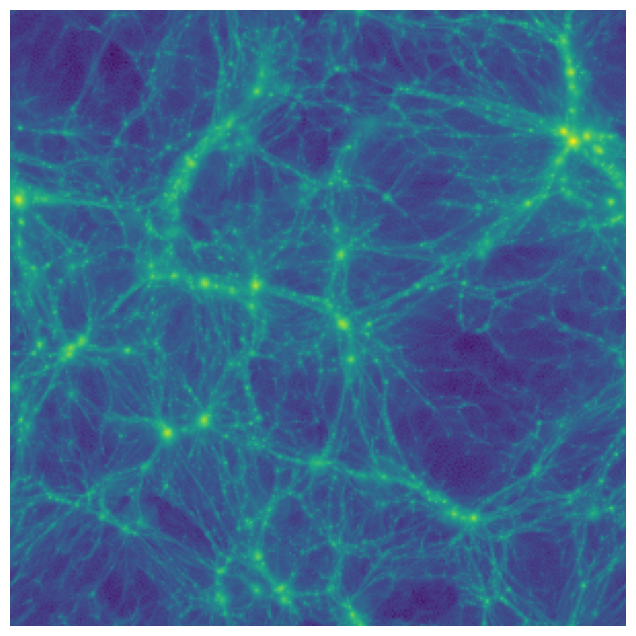

In [11]:
import matplotlib.pyplot as plt

min_z = 50000
max_z = 60000

slice_mask = (gas_data['Coordinates'][:, 2] >= min_z) & (gas_data['Coordinates'][:, 2] < max_z)

with h5py.File('tng100-3/output/snapdir_098/snap_098.0.hdf5', 'r') as snapfile:
    Lbox = snapfile['Header'].attrs['BoxSize']


fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(gas_data['Coordinates'][slice_mask, 0], gas_data['Coordinates'][slice_mask, 1], bins=300)
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='viridis', extent=(0, Lbox, 0, Lbox))
ax.set_axis_off()
fig.show()

Now the color shows the gas density! We can see that there are clumps of matter (in yellow) at the nodes of this web. These are the haloes we were talking about earlier. To convince ourselves, let's mark them

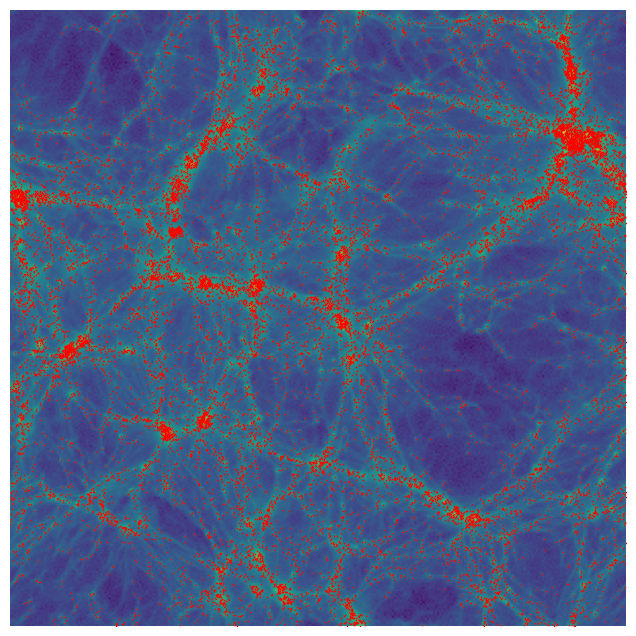

In [12]:
group_data = il.groupcat.loadHalos('tng100-3/output', 98, fields=['GroupPos', 'Group_M_Mean200'])
slice_mask_groups = (group_data['GroupPos'][:, 2] >= min_z) & (group_data['GroupPos'][:, 2] < max_z)


fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(gas_data['Coordinates'][slice_mask, 0], gas_data['Coordinates'][slice_mask, 1], bins=300)
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='viridis', extent=(0, Lbox, 0, Lbox))

ax.scatter(group_data['GroupPos'][slice_mask_groups, 0], group_data['GroupPos'][slice_mask_groups, 1], marker='x', c='r', s=0.1)

ax.set_axis_off()
fig.show()

### Other physical quantities
Using a 2D histogram makes it easy to show different physical quantities.

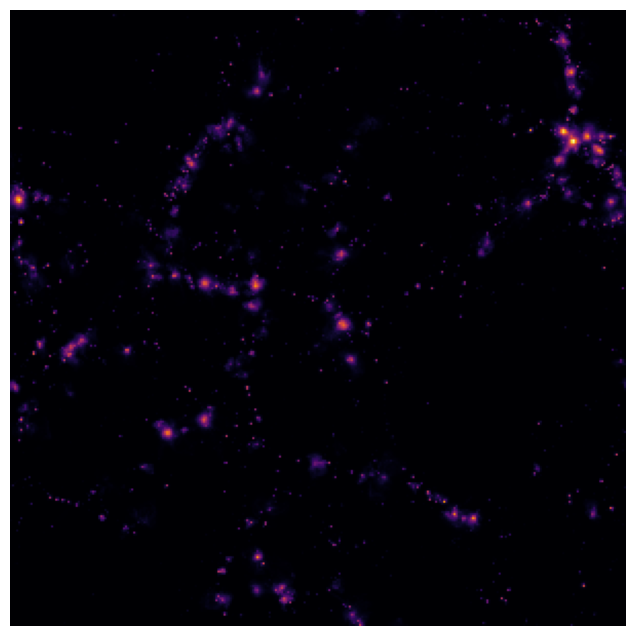

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(gas_data['Coordinates'][slice_mask, 0], gas_data['Coordinates'][slice_mask, 1], bins=300, weights=gas_data['GFM_Metallicity'][slice_mask])
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='inferno', extent=(0, Lbox, 0, Lbox))
ax.set_axis_off()
fig.show()

### Periodic Boundary Conditions
Cosmological simulations often use PBC. This is the simplest way to simulate an 'infinite' Universe. I practice, it means that if a particle crosses one edge of the simulation, it "enters" from the opposite side.

This also means that we can shift the center of the particle distribution to any point we want. For example:

In [14]:
def shift_center(positions, center):
    new_positions = positions - center + 0.5 * Lbox
    # apply PBC
    new_positions[new_positions < 0    ] += Lbox
    new_positions[new_positions >= Lbox] -= Lbox
    return new_positions

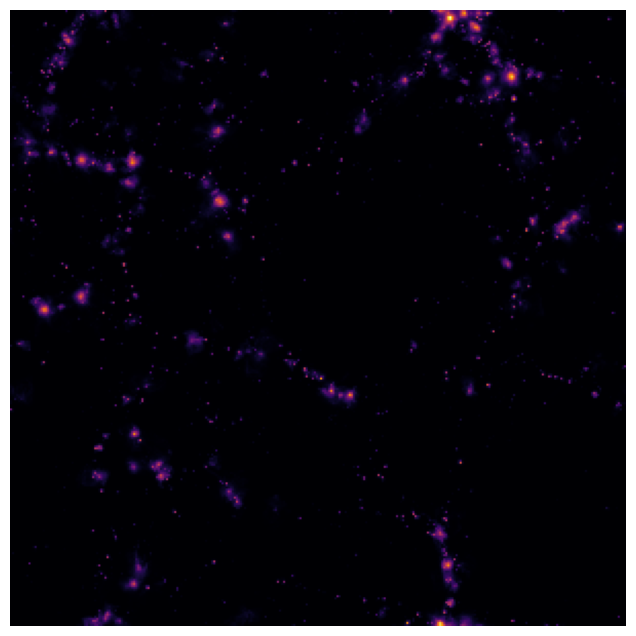

In [15]:
new_pos = shift_center(gas_data['Coordinates'], np.array([0.7, 0.3, 0.5])*Lbox)

slice_mask = (new_pos[:, 2] >= min_z) & (new_pos[:, 2] < max_z)

fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(new_pos[slice_mask, 0], new_pos[slice_mask, 1], bins=300, weights=gas_data['GFM_Metallicity'][slice_mask])
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='inferno', extent=(0, Lbox, 0, Lbox))
ax.set_axis_off()
fig.show()

## Individual galaxies
We can try now to visualize individual galaxies. For this, we have to:
* identify where galaxies are, using the group catalogs
* load all and only the particles that belong to a galaxy, using group catalogs + snapshots
* visualize them

We can use illustris_python to do the first two steps for us.

In [19]:
?il.snapshot.loadSubhalo

In [16]:
subhalo_id = 949

galaxy_data_gas   = il.snapshot.loadSubhalo('tng100-3/output', 98, subhalo_id, 0, fields=['Coordinates', 'Density', 'Velocities', 'GFM_Metallicity', 'InternalEnergy'])
galaxy_data_stars = il.snapshot.loadSubhalo('tng100-3/output', 98, subhalo_id, 4, fields=['Coordinates', 'GFM_StellarFormationTime'])

In [17]:
#center the galaxy
subhalo_data = il.groupcat.loadSubhalos('tng100-3/output', 98, fields=['SubhaloPos', 'SubhaloMassInRadType', 'SubhaloHalfmassRadType'])
galaxy_center = subhalo_data['SubhaloPos'][subhalo_id]
galaxy_data_gas['Coordinates']   = shift_center(galaxy_data_gas['Coordinates'], galaxy_center)
galaxy_data_stars['Coordinates'] = shift_center(galaxy_data_stars['Coordinates'], galaxy_center)

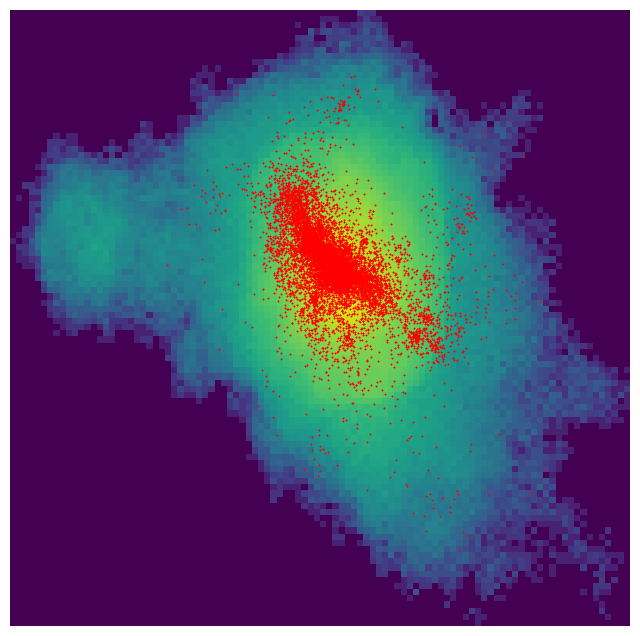

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(galaxy_data_gas['Coordinates'][:, 0], galaxy_data_gas['Coordinates'][:, 1], bins=100)
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='viridis', aspect='auto',
          extent=(galaxy_data_gas['Coordinates'][:, 0].min(), galaxy_data_gas['Coordinates'][:, 0].max(), galaxy_data_gas['Coordinates'][:, 1].min(), galaxy_data_gas['Coordinates'][:, 1].max()))
ax.scatter(galaxy_data_stars['Coordinates'][:, 0], galaxy_data_stars['Coordinates'][:, 1], marker='*', s=0.1, c='r')

ax.set_axis_off()
fig.show()

This shows us an important feture of galaxies. Stars are usually much more concentrated than gas! If you are not convinced, try changing the subhalo number and see!

Now let's have a closer look at the stars..

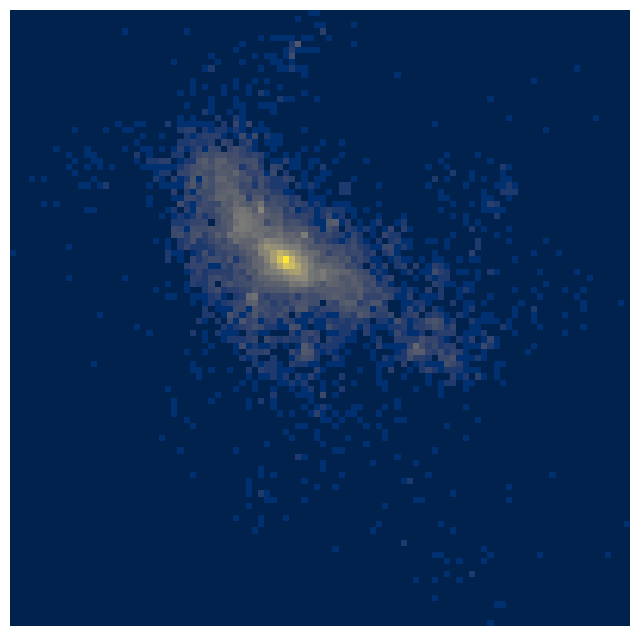

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))

#galaxy_stellar_radius = subhalo_data['SubhaloHalfmassRadType'][subhalo_id, 4]
#selection = np.linalg.norm(galaxy_data_stars['Coordinates'] - np.array([0.5, 0.5, 0.5])*Lbox, axis=1) < 2*galaxy_stellar_radius
selection = np.full_like(galaxy_data_stars['Coordinates'][:, 0], True, dtype=bool) #all particles

h2d, _, _ = np.histogram2d(galaxy_data_stars['Coordinates'][selection, 0], galaxy_data_stars['Coordinates'][selection, 1], bins=100)
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='cividis', aspect='auto',
          extent=(galaxy_data_stars['Coordinates'][selection, 0].min(), galaxy_data_stars['Coordinates'][selection, 0].max(), galaxy_data_stars['Coordinates'][selection, 1].min(), galaxy_data_stars['Coordinates'][selection, 1].max()))

ax.set_axis_off()
fig.show()

### hot vs cold gas

In [20]:
def computeParticlesTemperature(u, UnitVelocity_in_cm_per_s = 1e5, MeanMolecularWeight = 1, gamma = 5/3):
    """
    compute the temperature of the (gas) particles from their internal energy

    Parameters
    ----------

    u : numpy.array of float
        internal energy of the particles (as read from GADGET file). shape=(Npart)

    Returns
    -------
    temp : numpy.array of float
           temperature of the particles
    """

    BOLTZMANN = 1.3806e-16
    # units of u are energy/mass = (mass*length2/time2)/mass = (mass*length2/(length/velocity)2)/mass = velocity2
    PROTONMASS = 1.6726e-24  # g
    temp = MeanMolecularWeight*PROTONMASS/BOLTZMANN * (gamma-1) * u * UnitVelocity_in_cm_per_s**2

    return temp


In [21]:
galaxy_data_gas['Temperature'] = computeParticlesTemperature(galaxy_data_gas['InternalEnergy'])

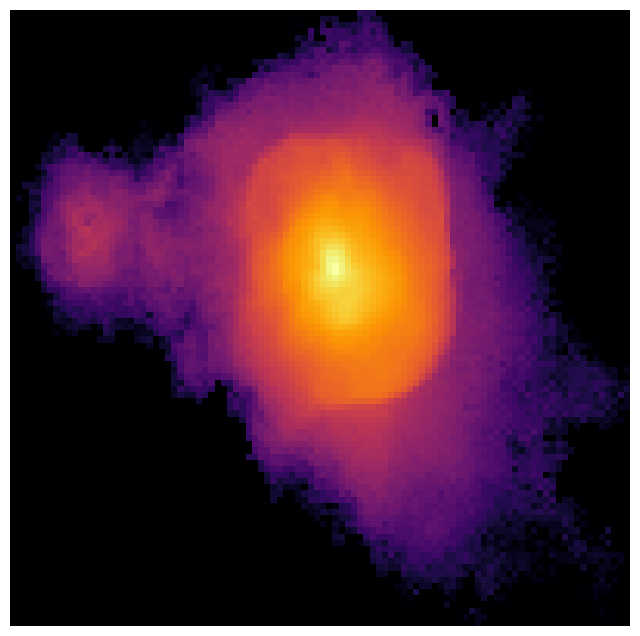

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(galaxy_data_gas['Coordinates'][:, 0], galaxy_data_gas['Coordinates'][:, 1], bins=100, weights=galaxy_data_gas['Density']*galaxy_data_gas['Temperature'])
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='inferno', aspect='auto',
          extent=(galaxy_data_gas['Coordinates'][:, 0].min(), galaxy_data_gas['Coordinates'][:, 0].max(), galaxy_data_gas['Coordinates'][:, 1].min(), galaxy_data_gas['Coordinates'][:, 1].max()))

ax.set_axis_off()
fig.show()

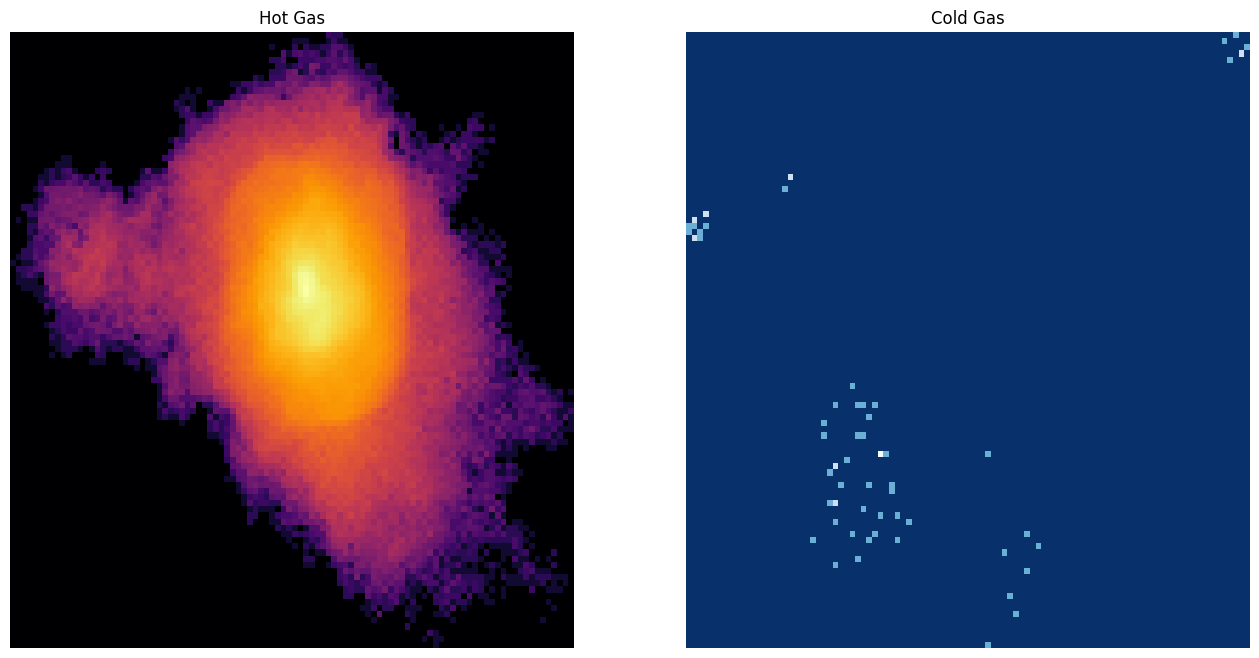

In [23]:
fig, ax = plt.subplots(1,2,figsize=(16, 8))

hot_gas_mask = galaxy_data_gas['Temperature'] > 1e7
cold_gas_mask = galaxy_data_gas['Temperature'] < 1e6

h2d, _, _ = np.histogram2d(galaxy_data_gas['Coordinates'][hot_gas_mask, 0], galaxy_data_gas['Coordinates'][hot_gas_mask, 1], bins=100)
ax[0].imshow(np.log10(h2d.T + 1), origin='lower', cmap='inferno', aspect='auto',
          extent=(galaxy_data_gas['Coordinates'][:, 0].min(), galaxy_data_gas['Coordinates'][:, 0].max(), galaxy_data_gas['Coordinates'][:, 1].min(), galaxy_data_gas['Coordinates'][:, 1].max()))

ax[0].set_title('Hot Gas')
ax[0].set_axis_off()

h2d, _, _ = np.histogram2d(galaxy_data_gas['Coordinates'][cold_gas_mask, 0], galaxy_data_gas['Coordinates'][cold_gas_mask, 1], bins=100)
ax[1].imshow(np.log10(h2d.T + 1), origin='lower', cmap='Blues_r', aspect='auto',
          extent=(galaxy_data_gas['Coordinates'][:, 0].min(), galaxy_data_gas['Coordinates'][:, 0].max(), galaxy_data_gas['Coordinates'][:, 1].min(), galaxy_data_gas['Coordinates'][:, 1].max()))

ax[1].set_title('Cold Gas')
ax[1].set_axis_off()
fig.show()

# Step 3: Phase-space diagram

In [24]:
gas_data = il.snapshot.loadSubset('tng100-3/output', 98, 0, fields=['Density', 'InternalEnergy'])

In [25]:
gas_data['Temperature'] = computeParticlesTemperature(gas_data['InternalEnergy'])

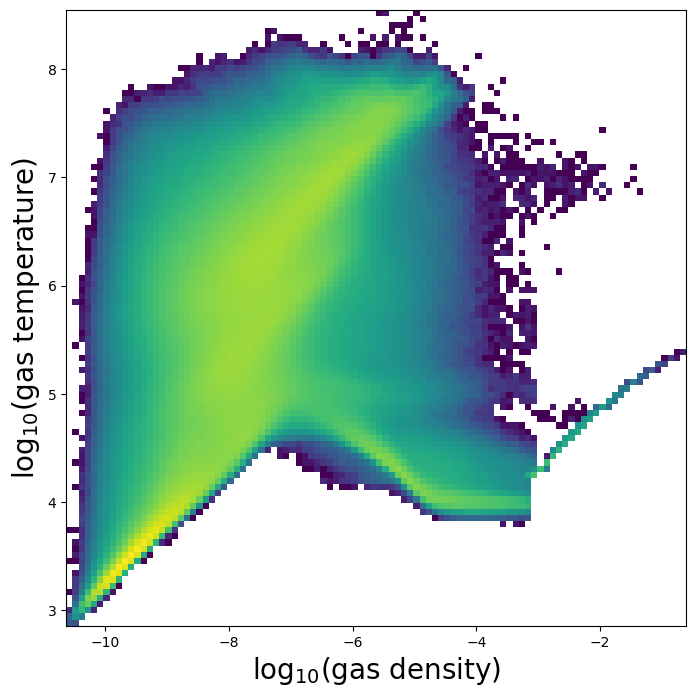

In [59]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(8, 8))
ax.hist2d(np.log10(gas_data['Density']), np.log10(gas_data['Temperature']), norm=LogNorm(), bins=100, cmap='viridis')

ax.set_xlabel(r'log$_{10}$(gas density)', fontsize=20)
ax.set_ylabel(r'log$_{10}$(gas temperature)', fontsize=20)

fig.show()

# Step 4: Halo mass function
The halo mass function (HMF) is a basic characterization of how many haloes (collapsed structures) exist as a function of their mass.

The HMF is important for many reasons, including:

* Testing Cosmological Models: the HMF changes depending on the amount of dark and non-dark matter in the Universe, how fast it is expanding, _what is_ dark matter, etc. We can compare the predicted HMF with observations to understand the composition of the Universe.
* Structure Formation: halos are the building blocks of cosmic structure. Galaxies and clusters of galaxies form within these halos. Knowing the HMF allow us to better understand how galaxies and other visible objects formed after the Big Bang.

Specifically, the HMF is defined as the number _density_ of haloes in a given mass range:

$$HMF = \frac{dN(M_0 \leq M_\mathrm{halo} < M_1)}{dV \, d\log(M)}$$

where:
* $dN(M_0 \leq M_\mathrm{halo} < M_1)$ is the number of haloes with mass between $M_0$ and $M_1$,
* $dV$ is the volume used for counting the haloes and
* $d\log(M) = \log(M_1) - \log(M_0)$.

Here, however, we will use the HMF in a different way, i.e. to test the reliability of our simulation.

First of all, let's compute the HMF.

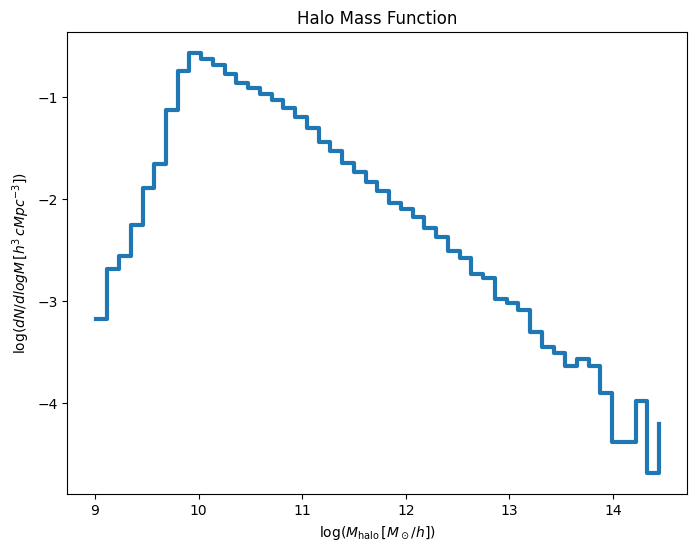

In [27]:
# AREPO stores the halo masses in internal units. In the case of TNG100-3, the unit mass is 10^10 M_sun/h
#   - h is the reduced Hubble constant, which accounts for the expansion of the Universe
#   - so far it did not matter, bu here we need the true mass, because we are dealing with physical quantities
halo_masses = group_data['Group_M_Mean200'] * 1e10 # M_sun/h

halo_masses = halo_masses[halo_masses > 0] #need to remove spurious structures

# Define bins of halo mass
Nbins = 50
log_masses = np.log10(halo_masses)
min_log_mass = log_masses.min()
max_log_mass = log_masses.max()
mass_bins = np.linspace(min_log_mass, max_log_mass, Nbins)


fig, ax = plt.subplots(figsize=(8, 6))

# count haloes of given mass and normalize
dN, _ = np.histogram(log_masses, bins=mass_bins)
dlogM = mass_bins[1] - mass_bins[0]
Lbox_in_cMpc = Lbox/1000
hmf = dN/dlogM/Lbox_in_cMpc**3

ax.step(mass_bins[:-1], np.log10(hmf), where='post', lw=3)

ax.set_xlabel(r'$\log(M_\mathrm{halo} \, [M_\odot/h])$')
ax.set_ylabel(r'$\log(dN/dlogM \, [h^3 \, cMpc^{-3}])$')
ax.set_title('Halo Mass Function')

fig.show()

Now let's compare this to some theoretical prediction. For this, we will use the `colossus` python package.

In [28]:
!pip install colossus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 kB 13.1 MB/s eta 0:00:00


In [29]:
from colossus.cosmology import cosmology

#set the cosmology parameters
with h5py.File('tng100-3/output/snapdir_098/snap_098.0.hdf5', 'r') as snapfile:
    cosmo_params = {
        'flat': True,
        'H0': snapfile['Header'].attrs['HubbleParam'] * 100, #units km/s/Mpc
        'Om0': snapfile['Header'].attrs['Omega0'],
        'Ode0': snapfile['Header'].attrs['OmegaLambda'],
        'Ob0': snapfile['Header'].attrs['OmegaBaryon'],
        'sigma8': 0.8159,
        'ns': 0.9667
    }
    #for later
    redshift = snapfile['Header'].attrs['Redshift']

cosmology.setCosmology('myCosmo', cosmo_params)

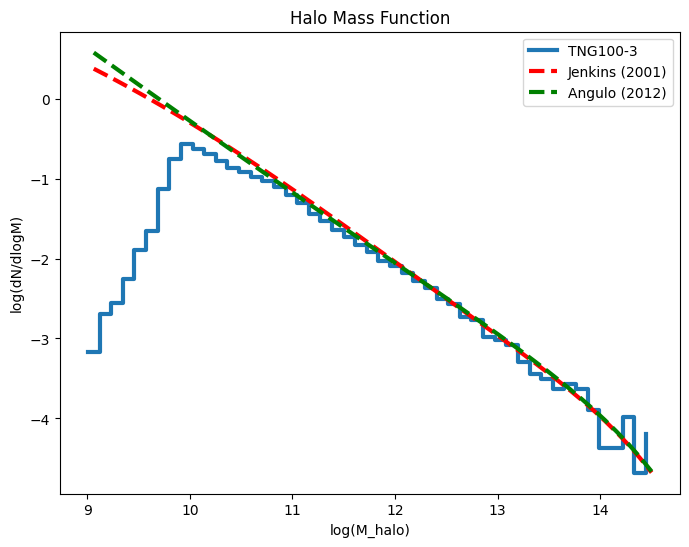

In [30]:
from colossus.lss import mass_function

# Colossus expects mass in Msun/h and computes dN/dln(M) -> we need to convert this to dN/dlog10(M)
bin_centers = (mass_bins[:-1] + mass_bins[1:]) * 0.5
jenkins_mf = mass_function.massFunction(10**bin_centers, redshift, mdef = 'fof', model = 'jenkins01', q_out = 'dndlnM')
jenkins_mf *= np.log(10)

angulo_mf = mass_function.massFunction(10**bin_centers, redshift, mdef = 'fof', model = 'angulo12', q_out = 'dndlnM')
angulo_mf *= np.log(10)

fig, ax = plt.subplots(figsize=(8, 6))

ax.step(mass_bins[:-1], np.log10(hmf), where='post', lw=3, label='TNG100-3')
ax.plot(bin_centers, np.log10(jenkins_mf), color='red', linestyle='--', lw = 3, label='Jenkins (2001)')
ax.plot(bin_centers, np.log10(angulo_mf), color='green', linestyle='--', lw = 3, label='Angulo (2012)')

ax.legend()
ax.set_xlabel('log(M_halo)')
ax.set_ylabel('log(dN/dlogM)')
ax.set_title('Halo Mass Function')

fig.show()

What is causing the big difference on the left side? To get a hint, let's mark the resolution of the simualation in the plot:

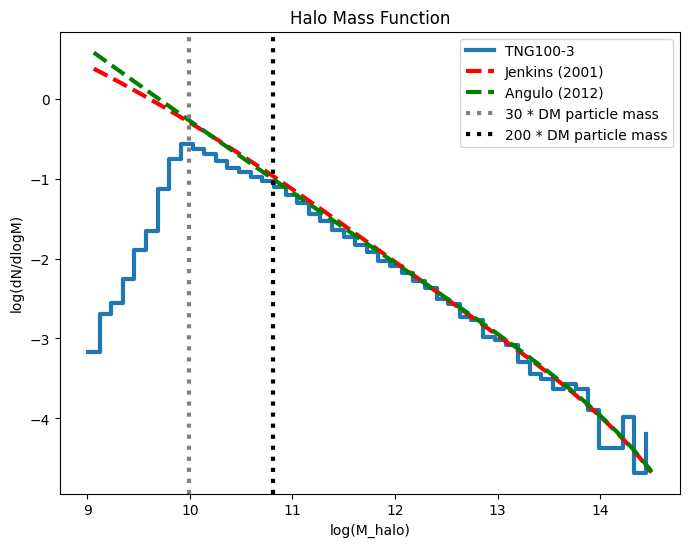

In [45]:
with h5py.File('tng100-3/output/snapdir_098/snap_098.0.hdf5', 'r') as snapfile:
    particle_mass = snapfile['Header'].attrs['MassTable'][1] * 1e10 #DM particles mass

fig, ax = plt.subplots(figsize=(8, 6))

ax.step(mass_bins[:-1], np.log10(hmf), where='post', lw=3, label='TNG100-3')
ax.plot(bin_centers, np.log10(jenkins_mf), color='red', linestyle='--', lw = 3, label='Jenkins (2001)')
ax.plot(bin_centers, np.log10(angulo_mf), color='green', linestyle='--', lw = 3, label='Angulo (2012)')
ax.axvline(np.log10(particle_mass * 30), color='grey', linestyle=':', lw = 3, label='30 * DM particle mass')
ax.axvline(np.log10(particle_mass * 200), color='k', linestyle=':', lw = 3, label='200 * DM particle mass')

ax.legend()
ax.set_xlabel('log(M_halo)')
ax.set_ylabel('log(dN/dlogM)')
ax.set_title('Halo Mass Function')

fig.show()

We can see that the simulations starts to predict _less_ haloes than expected when these haloes have less than 200 particles, and really fails miserably for haloes that have less than 20. This happens because we have reached the **resolution limit** of the simulation.

At or below the resolution limit, the structures are sampled too coarsely to provide reliable results.
* In this particular case, what happens is that the potential well of the halo cannot be resolved by few particles, so its gravitational attraction is artificially suppressed. This prevents other nearby particles from falling into the halo, and the overall mass is under-estimated.

This also means that all haloes with less than 20 particles (or equivalent mass) are not well simulated, so we can not trust them. From now on, we will get rid of them!

# Step 5: Stellar-to-halo mass relation

The stellar-to-halo mass relation (SHMR) is one of the most important relations in the study of galaxy formation. It quantifies the efficiency with which galaxies convert the available material into stars.

The SHMR is determined by the interaction between many different physical processes:
* Gas cooling and accretion: how gas falls into the halo and cools to form stars.
* Star formation efficiency: how effectively gas is converted into stars.
* Feedback mechanisms: How much and in which form energy from stars and black holes is injected into the galaxies.

This means that any model that tries to explain the Universe and the formation of galaxies, must produce a realistic SHMR.

Let's compute it for our simulation.

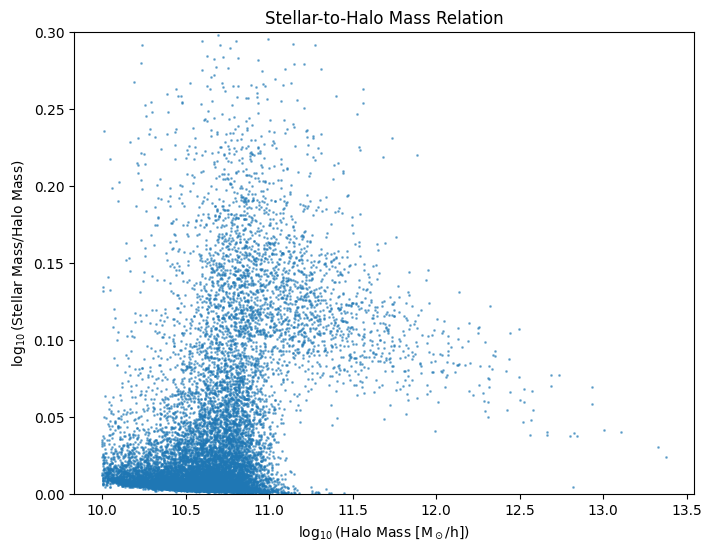

In [57]:
halo_masses = subhalo_data["SubhaloMassInRadType"].sum(axis=1) * 1e10 #Msun/h
stellar_masses = subhalo_data["SubhaloMassInRadType"][:,4] * 1e10 #Msun/h

#only consider resolved haloes
resolved = halo_masses > 1e10

stellar_to_halo_ratio = stellar_masses[resolved] / halo_masses[resolved]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the stellar-to-halo mass ratio vs halo mass
ax.scatter(np.log10(halo_masses[resolved]), stellar_to_halo_ratio, s=1, alpha=0.5)

ax.set_xlabel(r'$\log_{10}(\mathrm{Halo\ Mass\ [M_\odot/h]})$')
ax.set_ylabel(r'$\log_{10}(\mathrm{Stellar\ Mass} / \mathrm{Halo\ Mass})$')
ax.set_title('Stellar-to-Halo Mass Relation')

ax.set_ylim([0, 0.3])

fig.show()

## Exercise: understanding the SHMR

Now, we can try to understand what is the physics that produces the SHMR in pur simulation. A simple way to do so, is to color each point by some physical quantity and see if any of these quantities explains the SHMR.

Color the points in the plot with each one of the following quantities:
 - `SubhaloBHMass`
 - `SubhaloBHMdot`
 - `SubhaloGasMetallicity`
 - `SubhaloSFR`
 - sSFR = `SubhaloSFR`/M_star
 - `SubhaloSpin`
 - `SubhaloVel`


(hint: we have never loaded this quantities, so you will have to re-load the subhaloes and ask for these quantities as well)

(hint 2: some of these quantities span many orders of magnitude. If that's the case, try to use their logarithm to color the points)

/tmp/ipython-input-2819411402.py:22: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(halo_masses[resolved]), stellar_to_halo_ratio, s=1, alpha=0.5, c=np.log10(c))
/tmp/ipython-input-2819411402.py:37: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(halo_masses[resolved]), stellar_to_halo_ratio, s=1, alpha=0.5, c=np.log10(c))


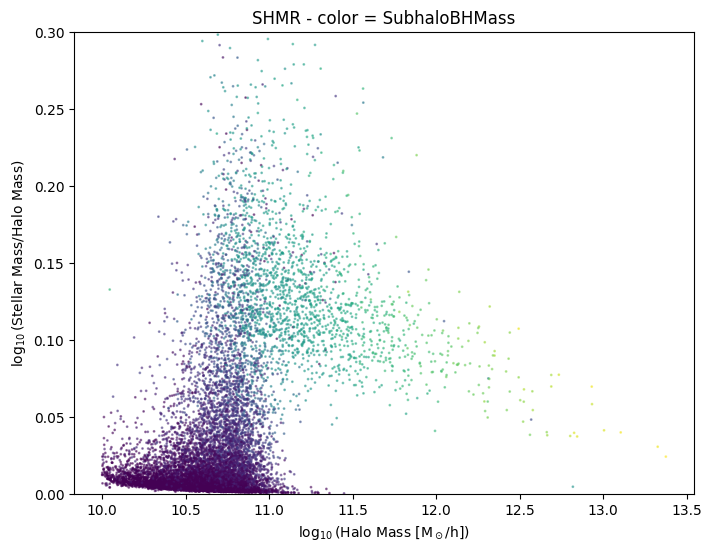

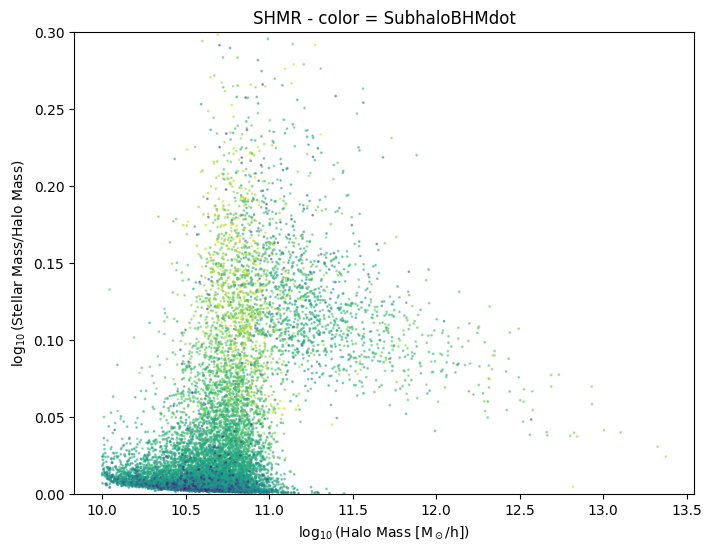

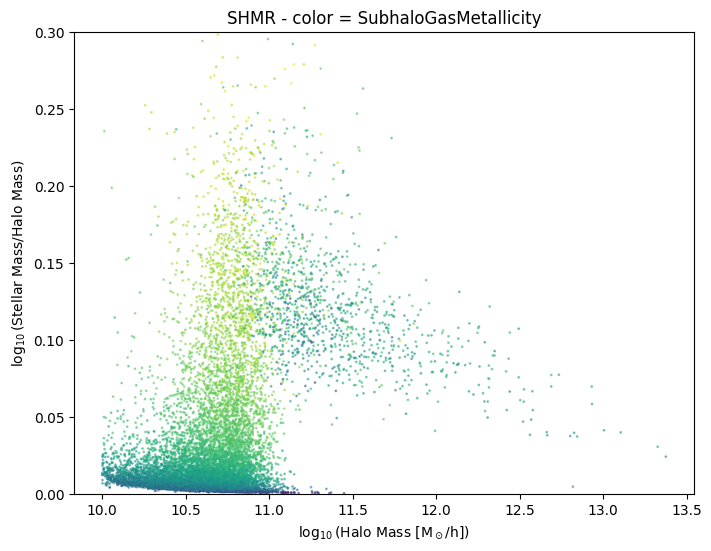

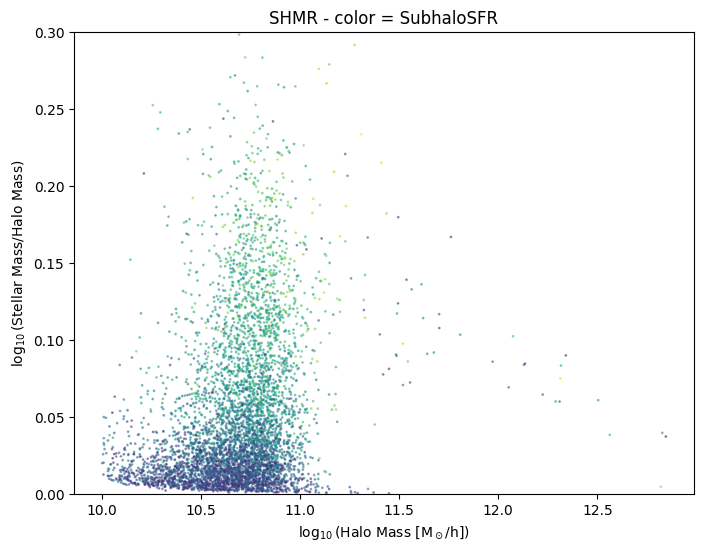

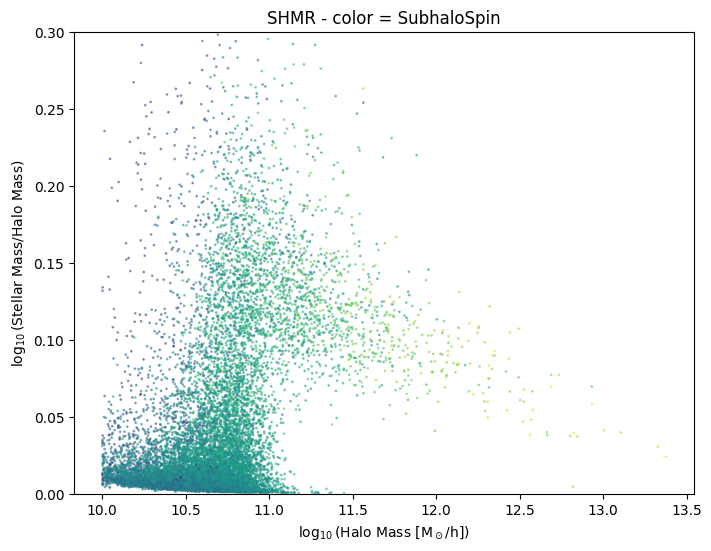

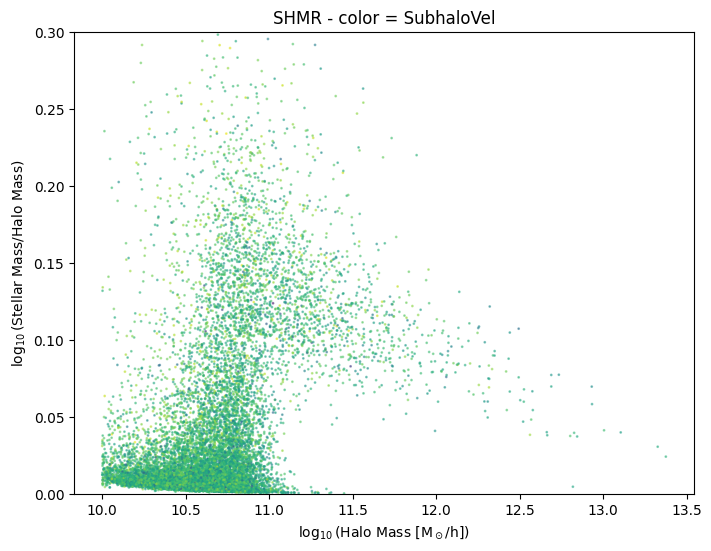

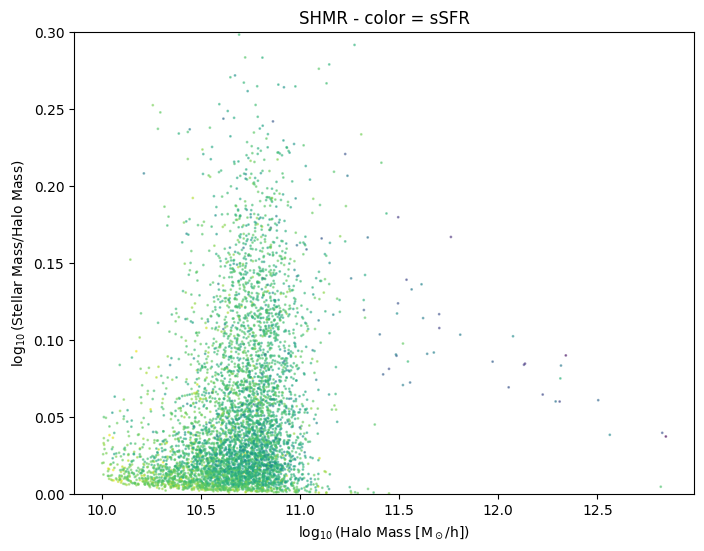

In [76]:
extra_fields = ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloGasMetallicity', 'SubhaloSFR', 'SubhaloSpin', 'SubhaloVel']

subhalo_data = il.groupcat.loadSubhalos('tng100-3/output', 98, fields=['SubhaloMassInRadType', *extra_fields])

halo_masses = subhalo_data["SubhaloMassInRadType"].sum(axis=1) * 1e10 #Msun/h
stellar_masses = subhalo_data["SubhaloMassInRadType"][:,4] * 1e10 #Msun/h

#only consider resolved haloes
resolved = halo_masses > 1e10

stellar_to_halo_ratio = stellar_masses[resolved] / halo_masses[resolved]

for field in extra_fields:

  fig, ax = plt.subplots(figsize=(8, 6))

  # Plot the stellar-to-halo mass ratio vs halo mass
  if field in ['SubhaloSpin', 'SubhaloVel']:
    c = np.linalg.norm(subhalo_data[field][resolved], axis=1)
  else:
    c = subhalo_data[field][resolved]
  ax.scatter(np.log10(halo_masses[resolved]), stellar_to_halo_ratio, s=1, alpha=0.5, c=np.log10(c))

  ax.set_xlabel(r'$\log_{10}(\mathrm{Halo\ Mass\ [M_\odot/h]})$')
  ax.set_ylabel(r'$\log_{10}(\mathrm{Stellar\ Mass} / \mathrm{Halo\ Mass})$')
  ax.set_title(f'SHMR - color = {field}')

  ax.set_ylim([0, 0.3])

  fig.show()

# sSFR
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the stellar-to-halo mass ratio vs halo mass
c = subhalo_data['SubhaloSFR'][resolved]/stellar_masses[resolved]
ax.scatter(np.log10(halo_masses[resolved]), stellar_to_halo_ratio, s=1, alpha=0.5, c=np.log10(c))

ax.set_xlabel(r'$\log_{10}(\mathrm{Halo\ Mass\ [M_\odot/h]})$')
ax.set_ylabel(r'$\log_{10}(\mathrm{Stellar\ Mass} / \mathrm{Halo\ Mass})$')
ax.set_title(f'SHMR - color = sSFR')

ax.set_ylim([0, 0.3])

fig.show()

# Step 6: Merger trees